In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from utils import get_words, save_img, resize, normalize_images, gen_alphabet
from highlight import HighlightWords
from keras.models import load_model
from keras.backend import set_learning_phase

Using TensorFlow backend.


In [2]:
def plot_img(img, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')

In [3]:
def process_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
    return img

In [4]:
def read_imgs(path, process=True):
    filenames = os.listdir(path)
    if process:
        imgs = [process_img(path + name) for name in filenames if not 'ipynb' in name and not 'DS' in name]
    else:
        imgs = [cv2.imread(path + name) for name in filenames if not 'ipynb' in name and not 'DS' in name ]
    return imgs

In [5]:
def read_one_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY_INV)[1]
    
    return img

In [6]:
path = 'course_project/test/x_test/'
filenames = os.listdir(path)
imgs = read_imgs(path)

originals = read_imgs(path, process=False)

In [7]:
%%time
model = load_model('course_project/Models/main_model.h5')
model.load_weights('course_project/Models/weights_15.h5')
set_learning_phase(0)

W0902 20:09:05.811589 4637234624 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 20:09:05.901329 4637234624 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 20:09:05.925413 4637234624 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 20:09:05.926064 4637234624 deprecation_wrapper.py:119] From /Users/svatoslavdarmograj/Documents/ml/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_sess

CPU times: user 56.6 s, sys: 1.41 s, total: 58 s
Wall time: 58.9 s


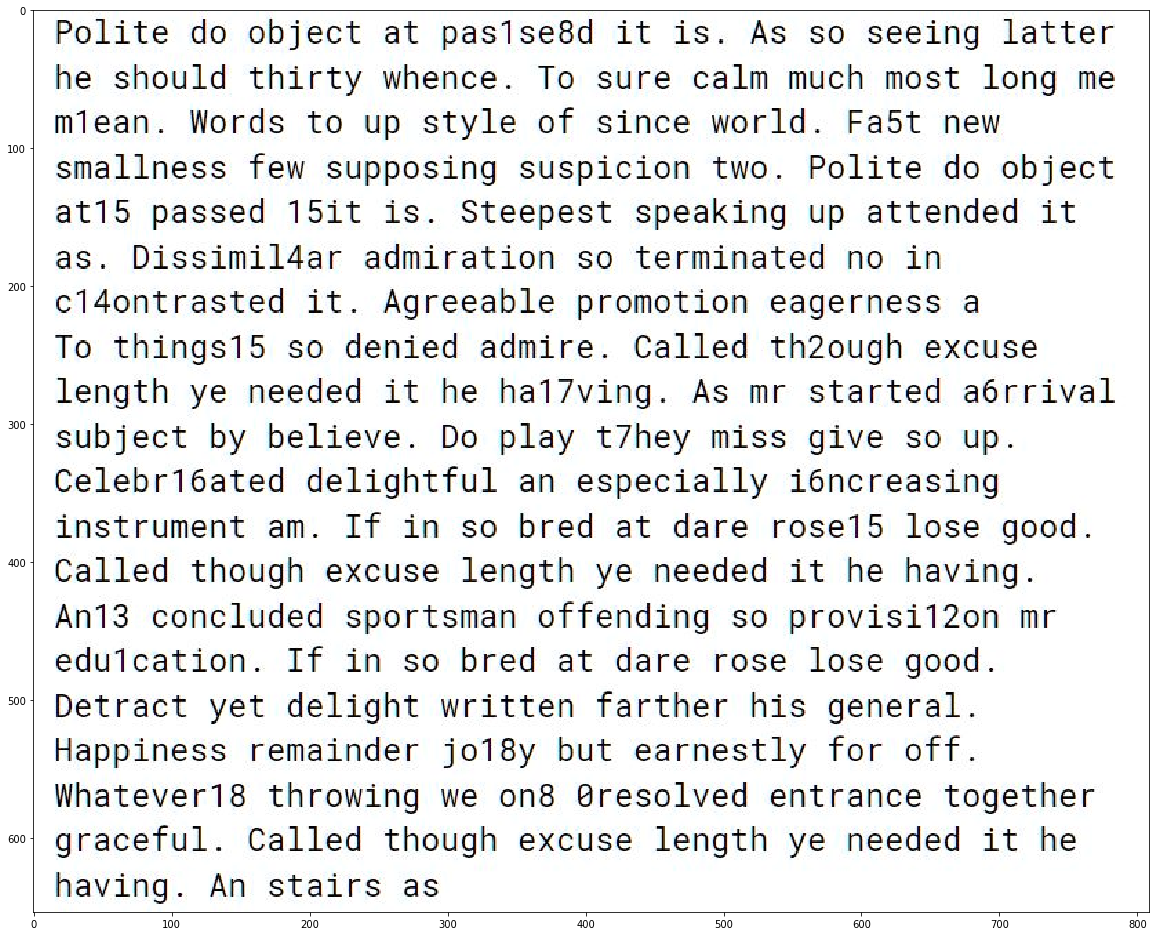

In [8]:
img = cv2.imread('course_project/test/x_test/1.JPG')
plot_img(img)

In [9]:
%%time
hw = HighlightWords(img, model=model)

CPU times: user 1min 26s, sys: 6.54 s, total: 1min 32s
Wall time: 48.7 s


In [10]:
hw._text

'polite do object at pas1se8d it is. as so seeing latter he should thirty whence. to sure calm much most long me m1een. words to up style of since world. fe5t new gmellnegs few suppoging guspicion two. polite do object at15 passed 15it is. steepest speaking up attended it as, d1ss1m114ar adm1tat10n s0 tetm1nated n0 1n c14ontrasted it. agreeable promotion eagerness a to things15 so denied admire. called thzough excuse length ye needed it he ha1zving. as mr started a6rrival subject by believe. do play t7hey miss give so up. celebr16eted delightful an egpecielly i6ncreeging ingtrument em. if in go bred et dere roge15 loge good. called though excuse length ye needed it he having. an13 concluded sportgmen offending so provisi12on mr edu1cetion. if in so bred et dere roge loge good. detract yet delight written ferther his generel. happinegg remeinder jo1&y but earnegtly for off. whatever18 throwing we on8 oresolved entrance together greceful. celled though excuse length ye needed it he havin

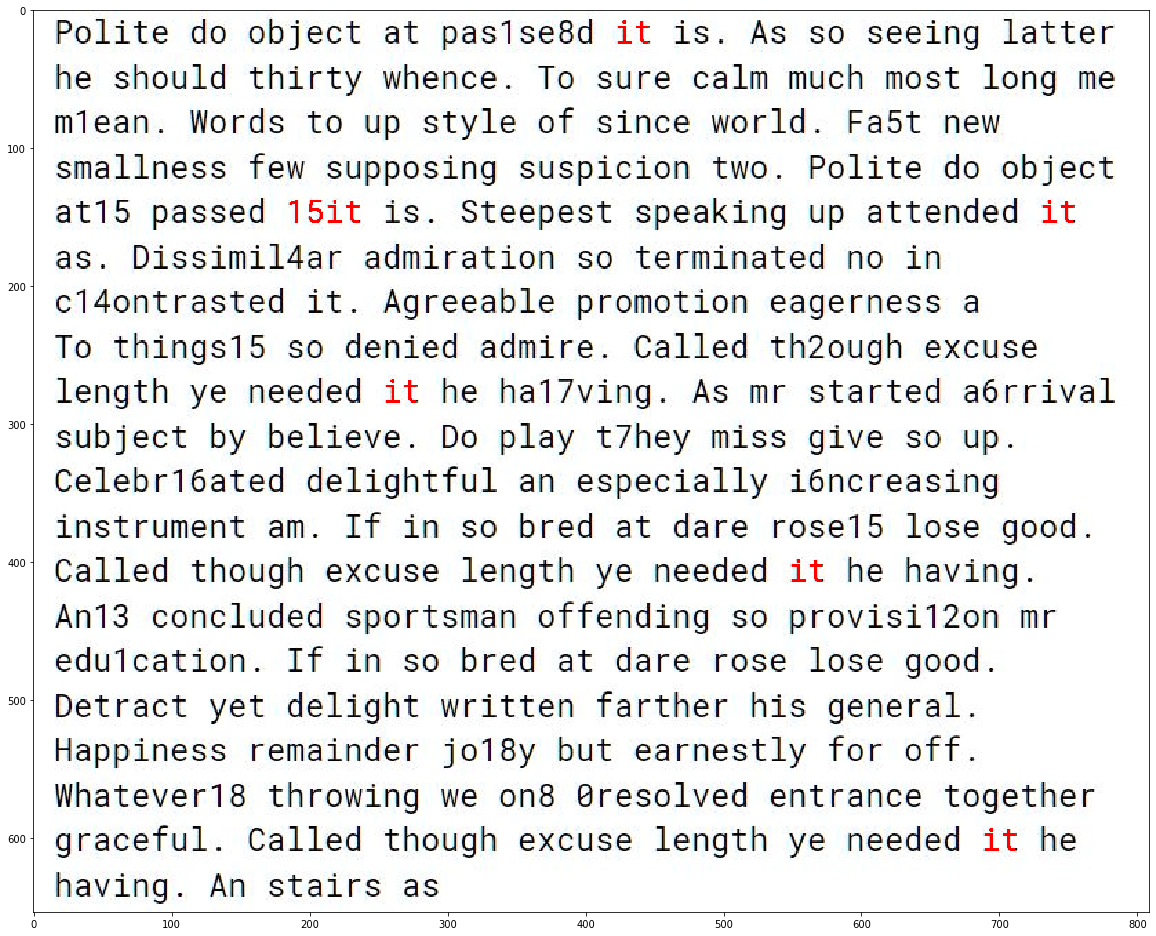

In [11]:
hw._most_frequent_word
plot_img(hw._highlighted_img)

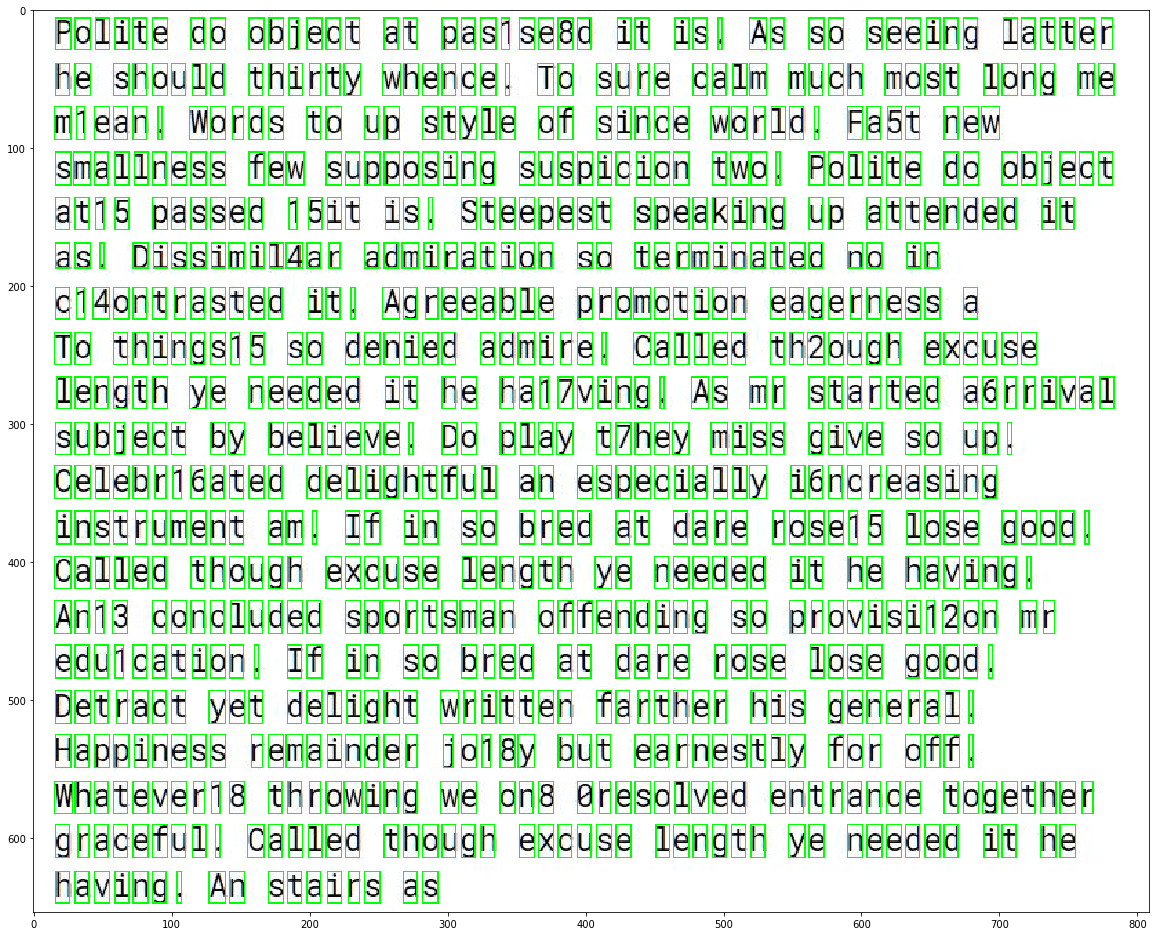

In [13]:
tmp_img = img.copy()
for word in hw._bboxes_chars:
    for x, y, w, h in word:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0))
plot_img(img)

In [ ]:
x, y, w, h = hw._bboxes_chars[7][0]
tmp_img = hw._thresholded_img[y:y+h, x:x+w]
# tmp_img = cv2.threshold(tmp_img, 1, 255, cv2.THRESH_BINARY)[1]
tmp_img = resize(hw._thresholded_img, (x, y, w, h))

# tmp_img = plt.imread('course_project/train/Abel/a.jpg')
# tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2GRAY)

tmp_img = normalize_images(tmp_img)

plt.imshow(tmp_img.reshape((28, 28)), cmap='gray')
gen_alphabet()[np.argmax(model.predict(tmp_img.reshape((1, 28, 28, 1))))]

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

In [ ]:
img = imgs[9].copy()
img_or = originals[9].copy()
plot_img(img)

In [ ]:
words, chars = get_words(img)

In [ ]:
for x, y, w, h in chars[0]:
    cv2.rectangle(img_or, (x, y), (x+w, y+h), (0, 255, 0))
plot_img(img_or)

In [ ]:
%%time
path_to_save = 'course_project/tested/'
for i, img in enumerate(imgs):
    words = get_words(img)
    temp_img = originals[i]
    for j, (x, y, w, h) in enumerate(words):
        cv2.rectangle(temp_img, (x, y), (x+w, y+h), (0, 255, 0))
    save_img(path_to_save, temp_img, '{}.jpg'.format(i))